In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "./../"
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

## Chapter 2. 不動産会社のデータサイエンティスト体験 (Pandas, sklearn入門)


- カリフォルニア州の国勢調査データを用いて任意の区画の住宅価格の中央値を予測したい


- 多変量回帰(multivariate regression)問題



(基本的にコードは著者のgithubに上がっているipynbからコピペしているので詳細はそちらを参照)

### 2.4 洞察を得るためにデータを研究、可視化する

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


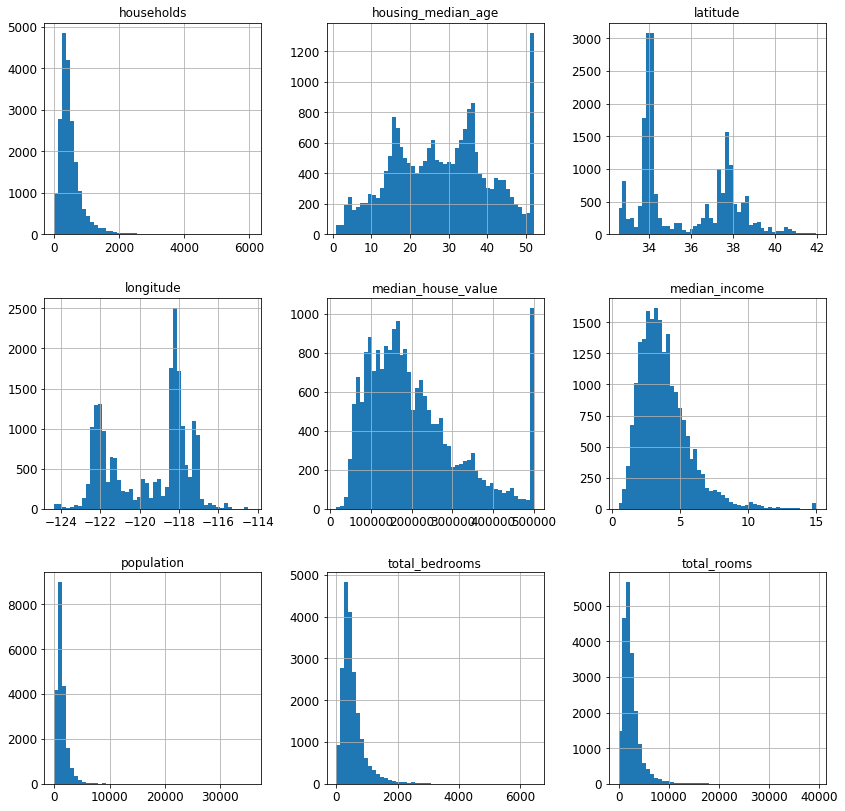

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(14,14))
#save_fig("attribute_histogram_plots")
plt.show()

In [5]:
import numpy as np
from zlib import crc32
import hashlib
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

# to make this notebook's output identical at every run
np.random.seed(42)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

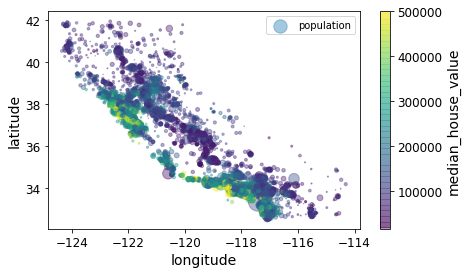

In [6]:
import matplotlib.image as mpimg
housing = strat_train_set.copy()

#housing.plot(kind="scatter", x="longitude", y="latitude",figsize=(6,4))

california_img=mpimg.imread(PROJECT_ROOT_DIR + './images/end_to_end_project/california.png')

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(7,4),
    c="median_house_value", cmap=plt.get_cmap("viridis"), colorbar=True,
    sharex=False)
#plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
#           cmap=plt.get_cmap("viridis"))
plt.legend()
#save_fig("housing_prices_scatterplot")
plt.show()

In [7]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

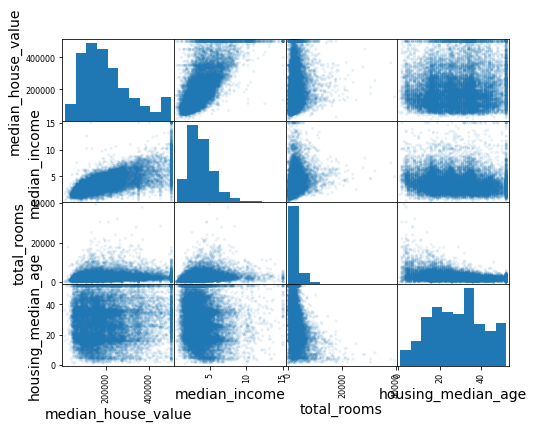

In [8]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(8, 6),alpha=0.1)
#save_fig("scatter_matrix_plot")
plt.show()

In [7]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
housing.shape

(16512, 9)

### 2.5.1 データを欠損値を落とし、中央値などで置き換える(クリーニング)
- sklearn.preprocessing のImputerが便利

```Python
imputer = Imputer(strategy="median")
```


### 2.5.2 テキスト、カテゴリ属性の処理
- one-hot encodingが便利
- テキストではfuture_encoders.py中に実装されている OneHotEncoderを用いている (sklearn.preprocessing.OneHotEncoderと仕様が違う...?)

### 2.5.3 カスタム変換器をつくる
- 例えば、特徴量として部屋数あたりの寝室数を加えるかどうかの変換器を<font color="Green">BaseEstimator</font>と<font color="Green">TransformerMixin</font>を使ってscikit-learn likeなクラスとして定義することができる
- なるべくデータ準備ステップは自動化したい(それはそう)

In [8]:
# page65 参照
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 2.5.4 特徴量スケーリング
- ごく一部の例外を除き、機械学習アルゴリズムは、**入力数値のスケールが大きく異なると性能を発揮できない**


- よく使われる方法は、min-max scaling (normalization,正規化) と standardization (標準化)


- min-max scaling では値を [0,1] に正規化する ← <font color="Green">from sklearn.preprocessing import MinMaxScaler</font>
    - 外れ値の影響が大きくなってしまう。。。


* standardization では値からmeanを引き、stdで割る(mean:0, std: 1)。← <font color="Green">from sklearn.preprocessing import StandardScaler</font>
    * Neural networkは入力値が0から1の間に収まっていることを前提にすることが多いので注意が必要

### 2.5.5 Pipeline の活用
- 順番の決まっているデータ前処理のステップをまとめて一行で書きたい...!
- <font color="Green">from sklearn.pipeline import Pipeline</font> を活用しよう
- 以下では 1.欠損値を中央値に置き換え、2.部屋数あたりの寝室数を特徴量として加え、3.データを標準化している。

```Python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
```

In [9]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from future_encoders import OneHotEncoder
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# DataFrameSelectorでDataFrameを数値データとカテゴリデータに分け、
#それぞれに異なるPipelineを充てる
# pipeline.FeatureUnionを利用することで異なるパイプラインを統合できる。
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [11]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [36]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## 2.6 モデルを選択して訓練する
### 2.6.1 訓練セットを訓練、評価する

In [23]:
# X  ただしocean_proximity は one hot encodingしてある
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [24]:
# target value: median_house_value
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

とりあえず線形回帰モデルを訓練してみる

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("linear regression mse: ",lin_rmse)
print("median house value std is ", housing_labels.values.std())

linear regression mse:  68628.19819848923
median house value std is  115699.51117337927


115699.51117337927

線形回帰だとunder-fittingが起こっていることが確認できる。

なのでより複雑なモデルとして、決定木(DecisionTreeRegressor)を用いる

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

どうもモデルがoverfittingを起こしている。なので以下のcross-validationを用いる
### 2.6.2 cross-validationを使ったfine-tuning
ここでは特に訓練データを10分割して、1つの validation data を回して検証を行う10-fold validationを行う

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70232.0136482  66828.46839892 72444.08721003 70761.50186201
 71125.52697653 75581.29319857 70169.59286164 70055.37863456
 75370.49116773 71222.39081244]
Mean: 71379.07447706361
Standard deviation: 2458.3188204349362


In [39]:
#cross-validationの結果、DecisionTreeRegressionはLinearRegressionとほとんど変わらない。

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983484


最後にRandomForestRegressorの実装をしてみる

In [41]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Random forest mse for training; ",forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Random forest mse for training;  21941.911027380233
Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard deviation: 2301.873803919754


### 2.7.1 GridSearchを用いた hyperparameter tuning
- 例えばRandomForestRegressionの場合...

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.85444595992 {'max_features': 2, 'n_estimators': 3}
55611.50159876327 {'max_features': 2, 'n_estimators': 10}
53370.06407363344 {'max_features': 2, 'n_estimators': 30}
60959.138858487866 {'max_features': 4, 'n_estimators': 3}
52740.58416665252 {'max_features': 4, 'n_estimators': 10}
50374.14214614731 {'max_features': 4, 'n_estimators': 30}
58661.2866461823 {'max_features': 6, 'n_estimators': 3}
52009.973979776936 {'max_features': 6, 'n_estimators': 10}
50154.11777368494 {'max_features': 6, 'n_estimators': 30}
57865.36168014446 {'max_features': 8, 'n_estimators': 3}
51730.07550866553 {'max_features': 8, 'n_estimators': 10}
49694.85143334442 {'max_features': 8, 'n_estimators': 30}
62874.407393096284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.49980834466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.89228588419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.358293621044 {'bootstrap': False, 'max_features': 3, 'n_estimators':

- hyperparameterの数が多くなってくるとGridSearchだとつらいので、RandomizedSearchCVを使った方が計算資源の管理がしやすいし、広いパラメータスペースが探索できる。
- 場合によっては、個別のモデルを組み合わせるのも効果的。質の異なるモデルを組み合わせると良いらしい。。

### 2.7.4 最良のモデルの分析
- RandomForestRegressorだと、個々のfeatureの相対的な重要性を列挙することが可能。(計100%で寄与度みたいなものが計算されている...?)

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

### 2.7.5 最後は test set で性能評価

In [48]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("final_rmse: ",final_rmse)
print("cross-validation rmse: ",49694.85143334442)

final_rmse:  47766.00396643308
cross-validation rmse:  49694.85143334442


めずらしく(?) training setでのcross validationよりtest setの方が成績が良い。

scipyを使えばtest set のrmseに対する 95%信頼区間も計算できる

In [50]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45720.21311746, 49727.70236334])